### Utils

In [9]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
"""

import numpy as np
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt
import torch

def normalize_adjacency(A):
    # Normalizes adjacency matrix represnted as a sparse SciPy matrix
    n = A.shape[0]
    A += sp.identity(n)
    degs = A.dot(np.ones(n))
    inv_degs = np.power(degs, -1)
    D_inv = sp.diags(inv_degs)
    A_normalized = D_inv.dot(A)
    return A_normalized

def sparse_mx_to_torch_sparse(M):
    # Converts a sparse SciPy matrix to a sparse PyTorch tensor
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def find_communities_and_plot(G):
    # Compute the best partition using Louvain algorithm
    partition = nx.community.louvain_communities(G)

    # Reorder the adjacency matrix
    ordered_nodes = list()
    for p in partition:
        for node in p:
            ordered_nodes.append(node)

    reordered_matrix = nx.to_numpy_array(G, nodelist=ordered_nodes)

    # Plot adjacency matrix
    plt.imshow(reordered_matrix, cmap='gray')
    plt.title("Reordered Adjacency Matrix")
    plt.show()

    # Draw the graph
    plt.title('Generated graph')
    nx.draw(G)
    plt.show()

### Model

In [10]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
"""
!pip install torch-geometric
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import global_add_pool

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, n_layers, n_nodes, dropout=0.2):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.n_nodes = n_nodes

        self.fc = nn.ModuleList()
        self.fc.append(nn.Sequential(nn.Linear(latent_dim, hidden_dim),
                            nn.ReLU(),
                            nn.LayerNorm(hidden_dim),
                            nn.Dropout(dropout)
                            ))

        for i in range(1, n_layers):
            self.fc.append(nn.Sequential(nn.Linear(hidden_dim*i, hidden_dim*(i+1)),
                            nn.ReLU(),
                            nn.LayerNorm(hidden_dim*(i+1)),
                            nn.Dropout(dropout)
                            ))

        self.fc_proj = nn.Linear(hidden_dim*n_layers, n_nodes*n_nodes)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        ############## Task 10

        ##################
        for i in range(self.n_layers):
          x = self.fc[i](x)
        x = self.fc_proj(x)
        x = x.reshape(-1,self.n_nodes,self.n_nodes)
        adj = 0.5*(x+torch.transpose(x,1,2))
        #do not neet to add sigmoid because integrated in loss function
        ##################

        return adj

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_layers, dropout=0.2):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.mlps = torch.nn.ModuleList()
        self.mlps.append(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU()
                            ))

        for layer in range(n_layers-1):
            self.mlps.append(nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU()
                            ))

        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, adj, x, idx):
        ############## Task 8

        ##################
        for i in range(self.n_layers):
          x = torch.mm(adj,x)
          x = self.mlps[i](x)

        #################code here ##

        # Readout
        idx = idx.unsqueeze(1).repeat(1, x.size(1))
        out = torch.zeros(torch.max(idx)+1, x.size(1), device=x.device, requires_grad=False)
        out = out.scatter_add_(0, idx, x)

        out = self.fc(out)
        return out


# Variational Autoencoder
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim_enc, hidden_dim_dec, latent_dim, n_layers_enc, n_layers_dec, n_max_nodes):
        super(VariationalAutoEncoder, self).__init__()
        self.n_max_nodes = n_max_nodes
        self.input_dim = input_dim
        self.encoder = Encoder(input_dim, hidden_dim_enc, hidden_dim_enc, n_layers_enc)
        self.fc_mu = nn.Linear(hidden_dim_enc, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim_enc, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim_dec, n_layers_dec, n_max_nodes)

    def reparameterize(self, mu, logvar, eps_scale=1.):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.randn_like(std) * eps_scale
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, mu):
        adj = self.decoder(mu)
        adj = torch.sigmoid(adj)
        adj = adj * (1 - torch.eye(adj.size(-2), adj.size(-1), device=adj.device))
        return adj

    def loss_function(self, adj, x, idx, y, beta=0.05):
        x_g  = self.encoder(adj, x, idx)

        ############## Task 9

        mu = self.fc_mu(x_g)# your code here
        logvar = self.fc_logvar(x_g) # your code here

        x_g = self.reparameterize(mu, logvar)
        adj = self.decoder(x_g)

        triu_idx = torch.triu_indices(self.n_max_nodes, self.n_max_nodes)
        recon = F.binary_cross_entropy_with_logits(adj[:,triu_idx[0,:],triu_idx[1,:]], y[:,triu_idx[0,:],triu_idx[1,:]], reduction='sum', pos_weight=torch.tensor(1./0.4))
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon + beta*kld

        return loss, recon, kld

### Main

Epoch: 0005, Train Loss: 411.32898, Train Reconstruction Loss: 410.46, Train KLD Loss: 17.35, Val Loss: 409.53381, Val Reconstruction Loss: 408.19, Val KLD Loss: 26.95
Epoch: 0010, Train Loss: 356.86954, Train Reconstruction Loss: 355.48, Train KLD Loss: 27.87, Val Loss: 365.60226, Val Reconstruction Loss: 364.12, Val KLD Loss: 29.62
Epoch: 0015, Train Loss: 343.74033, Train Reconstruction Loss: 342.17, Train KLD Loss: 31.43, Val Loss: 354.22089, Val Reconstruction Loss: 352.59, Val KLD Loss: 32.61
Epoch: 0020, Train Loss: 335.48181, Train Reconstruction Loss: 333.70, Train KLD Loss: 35.62, Val Loss: 347.46918, Val Reconstruction Loss: 345.62, Val KLD Loss: 37.00
Epoch: 0025, Train Loss: 315.12845, Train Reconstruction Loss: 312.99, Train KLD Loss: 42.86, Val Loss: 323.32022, Val Reconstruction Loss: 321.11, Val KLD Loss: 44.13
Epoch: 0030, Train Loss: 306.76071, Train Reconstruction Loss: 304.60, Train KLD Loss: 43.16, Val Loss: 317.30014, Val Reconstruction Loss: 315.06, Val KLD Loss

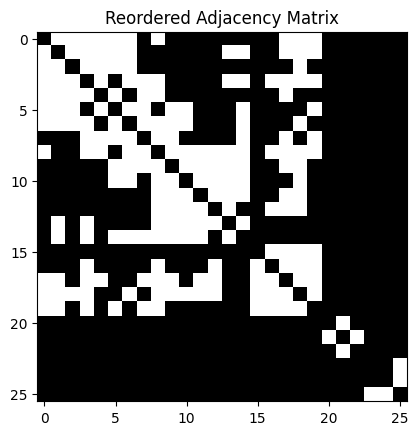

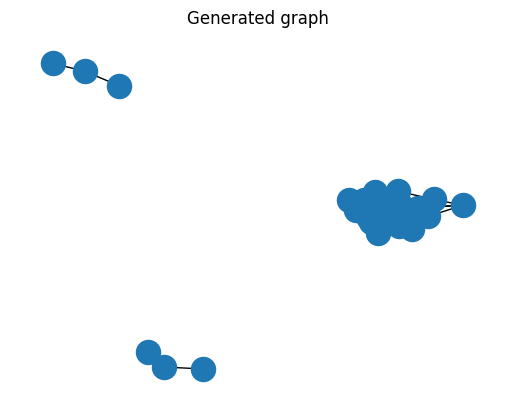

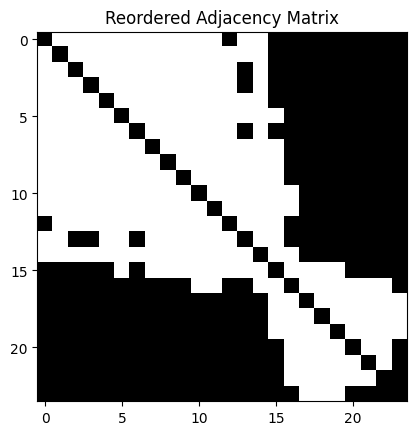

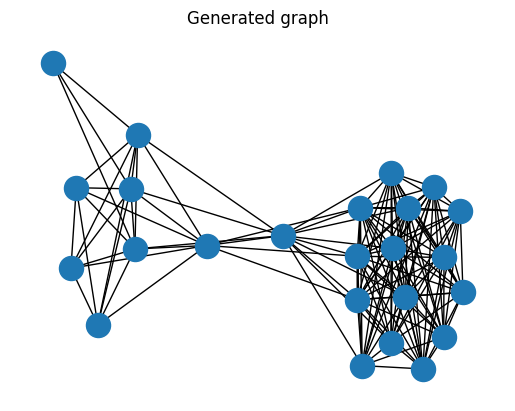

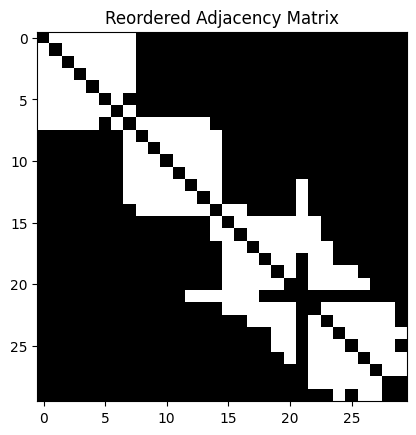

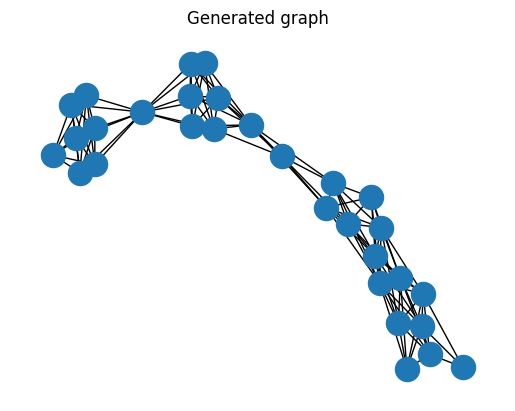

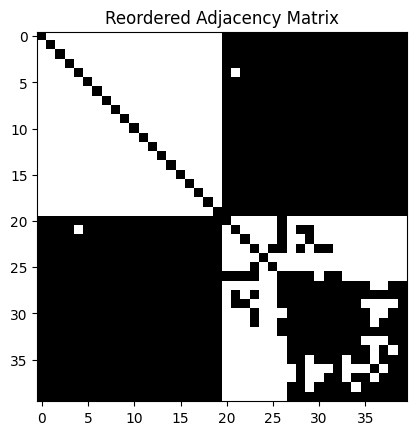

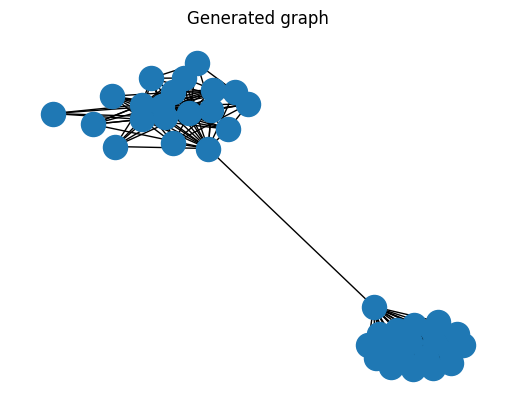

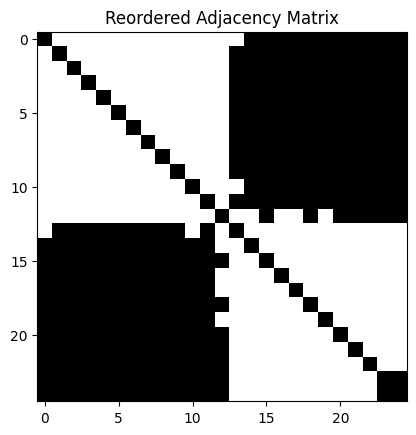

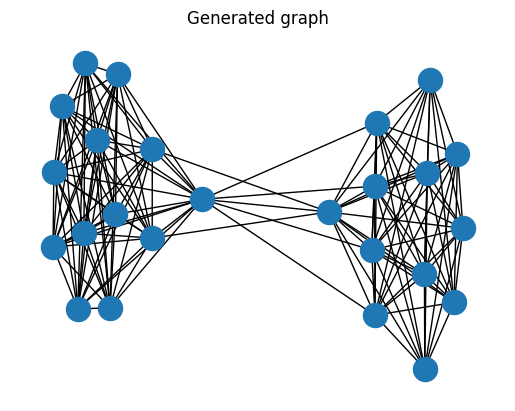

In [14]:
"""
Learning on Sets and Graph Generative Models - ALTEGRAD - Nov 2023
"""

import networkx as nx
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

from random import shuffle
from scipy.io import loadmat

import torch
import torch.nn.functional as F

#from model import VariationalAutoEncoder
#from utils import normalize_adjacency, sparse_mx_to_torch_sparse, find_communities_and_plot

np.random.seed(13)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
epochs = 100
batch_size = 32
hidden_dim_encoder = 32
n_layers_encoder = 2
latent_dim = 16
hidden_dim_decoder = 32
n_layers_decoder = 2
max_nodes = 40
input_feats = 2

# Load dataset
#adj_dict = loadmat("../data/sbm.mat")
adj_dict = loadmat("/content/sbm.mat")
adj = [adj_dict['G'+str(i)] for i in range(1000)]
n_graphs = len(adj)

# Normalize adjacency matrices
adj_normalized = [normalize_adjacency(adj[i]) for i in range(len(adj))]

# Compute node features
x = list()
for i in range(len(adj)):
    n = adj[i].shape[0]
    v = np.zeros((n,2))
    v[:,0] = adj[i].dot(np.ones(n))/max_nodes
    v[:,1] = adj[i].dot(v[:,0])/max_nodes
    x.append(v)

# Slit into training and validation sets
idx = np.random.permutation(n_graphs)
train_idx = [int(i) for i in idx[:int(0.9*idx.size)]]
val_idx = [int(i) for i in idx[int(0.9*idx.size):]]

n_train = len(train_idx)
n_val = len(val_idx)

# Initialize autoencoder
autoencoder = VariationalAutoEncoder(input_feats, hidden_dim_encoder, hidden_dim_decoder, latent_dim, n_layers_encoder, n_layers_decoder, max_nodes).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# Train autoencoder
best_val_loss = np.inf
for epoch in range(1, epochs+1):
    autoencoder.train()
    train_loss_all = 0
    train_count = 0
    train_loss_all_recon = 0
    train_loss_all_kld = 0

    shuffle(train_idx)

    for i in range(0, n_train, batch_size):
        adj_batch = list()
        x_batch = list()
        idx_batch = list()
        y_batch = list()
        for j in range(i, min(n_train, i+batch_size)):
            n = adj[train_idx[j]].shape[0]
            adj_batch.append(adj_normalized[train_idx[j]])
            x_batch.append(x[train_idx[j]])
            idx_batch += [j-i]*n
            y_batch.append(np.expand_dims(np.pad(adj[train_idx[j]].todense(), ((0,max_nodes-n),(0,max_nodes-n))), axis=0))

        adj_batch = sp.block_diag(adj_batch)
        x_batch = np.vstack(x_batch)
        y_batch = np.vstack(y_batch)

        adj_batch = sparse_mx_to_torch_sparse(adj_batch).to(device)
        x_batch = torch.FloatTensor(x_batch).to(device)
        idx_batch = torch.LongTensor(idx_batch).to(device)
        y_batch = torch.FloatTensor(y_batch).to(device)

        optimizer.zero_grad()
        loss, recon, kld  = autoencoder.loss_function(adj_batch, x_batch, idx_batch, y_batch)
        train_loss_all_recon += recon.item()
        train_loss_all_kld += kld.item()
        loss.backward()
        train_loss_all += loss.item()
        train_count += torch.max(idx_batch)+1
        optimizer.step()

    autoencoder.eval()
    val_loss_all = 0
    val_count = 0
    val_loss_all_recon = 0
    val_loss_all_kld = 0

    for i in range(0, n_val, batch_size):
        adj_batch = list()
        x_batch = list()
        idx_batch = list()
        y_batch = list()
        for j in range(i, min(n_val, i+batch_size)):
            n = adj[val_idx[j]].shape[0]
            adj_batch.append(adj_normalized[val_idx[j]])
            x_batch.append(x[val_idx[j]])
            idx_batch += [j-i]*n
            y_batch.append(np.expand_dims(np.pad(adj[val_idx[j]].todense(), ((0,max_nodes-n),(0,max_nodes-n))), axis=0))

        adj_batch = sp.block_diag(adj_batch)
        x_batch = np.vstack(x_batch)
        y_batch = np.vstack(y_batch)

        adj_batch = sparse_mx_to_torch_sparse(adj_batch).to(device)
        x_batch = torch.FloatTensor(x_batch).to(device)
        idx_batch = torch.LongTensor(idx_batch).to(device)
        y_batch = torch.FloatTensor(y_batch).to(device)

        loss, recon, kld  = autoencoder.loss_function(adj_batch, x_batch, idx_batch, y_batch)
        val_loss_all_recon += recon.item()
        val_loss_all_kld += kld.item()
        val_loss_all += loss.item()
        val_count += torch.max(idx_batch)+1

    if epoch % 5 == 0:
        print('Epoch: {:04d}, Train Loss: {:.5f}, Train Reconstruction Loss: {:.2f}, Train KLD Loss: {:.2f}, Val Loss: {:.5f}, Val Reconstruction Loss: {:.2f}, Val KLD Loss: {:.2f}'.format(epoch, train_loss_all/train_count, train_loss_all_recon/train_count, train_loss_all_kld/train_count, val_loss_all/val_count, val_loss_all_recon/val_count, val_loss_all_kld/val_count))

autoencoder.eval()


############## Task 11
z = torch.randn(5,latent_dim) # your code here #
adj = autoencoder.decode(z.to(device)) # your code here #


# Create and visualize graphs
for i in range(adj.size(0)):
    A = adj[i,:,:].detach().cpu().numpy()
    A[A>=0.5] = 1
    A[A<0.5] = 0
    G = nx.from_numpy_array(A)
    to_remove = list()
    for node in G.nodes():
        if G.degree(node) == 0:
            to_remove.append(node)
    G.remove_nodes_from(to_remove)
    find_communities_and_plot(G)